In [1]:
import lda
from scipy import sparse
import numpy as np
import json
import gensim 

unable to import 'smart_open.gcs', disabling that module


In [2]:
X_train = sparse.load_npz('/Users/tingchen/Desktop/Yelp Project/data_n_20_removed/X_train.npz')
cc= np.load("/Users/tingchen/Desktop/Yelp Project/data_n_20_removed/y_train.npy")

In [3]:
locs = []
with open("/Users/tingchen/Desktop/Yelp Project/locs_train.json", 'r') as file:
    locs = json.load(file)

In [4]:
ix = X_train.getnnz(1)>0
X_train = X_train[ix]
cc= cc[ix]
locs= np.array(locs)[ix]

In [5]:
# locations of each ethnicity
locs_eth = [[] for eth in range(3)]
indicies_locs_eth = []

for i, c in enumerate(cc):
    locs_eth[c].append(locs[i])
    indicies_locs_eth.append(len(locs_eth[c]) -1)

In [6]:
indicies_locs_eth = np.array(indicies_locs_eth, dtype=np.intc) 

In [7]:
reg_assign = []

with open('region_fluid_assignmentss.json', 'r',encoding='utf-8') as file:
    reg_assign = json.load(file)

In [8]:
for i, elem in enumerate(reg_assign):
    reg_assign[i] = np.array(elem, dtype=np.intc)

In [ ]:
#first = 70000

model = lda.LDA(n_topics= 40, region_assignments=reg_assign, indices_region_assignments=indicies_locs_eth, n_iter=700)
model.fit_fluid(X_train.astype(np.int32), cc.astype(np.int32), locs)

all zero column in document-term matrix found
/Users/tingchen/Desktop/Yelp_Cultural_Analysis/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


Finished initializing
0/700
10/700
20/700
30/700
40/700
50/700
60/700
70/700
80/700
90/700
100/700
110/700
120/700
130/700
140/700
150/700
160/700
170/700
180/700
190/700
200/700


In [ ]:
dic = gensim.corpora.Dictionary.load("/Users/tingchen/Desktop/Yelp Project/big_lexicon_n_20_removed")

In [ ]:
n_top_words = 15
n_regions = [5, 7, 6]
topic_word = model.topic_word_  
collection_word = model.topic_word_collection_ 

collections = ['Chinese', 'Italian', 'Mexican']
colors= ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink']

lexicon = np.array(list(dic.values()))

for i, topic_dist in enumerate(topic_word):
    topic_words = lexicon[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}\n'.format(i, ' '.join(topic_words)))
    
    for j, eth in enumerate(collections):
        print('Cuisine {}:'.format(eth))
        
        region_words = collection_word[j][i, :, :]

        for k in range(n_regions[j]):
            topic_words = lexicon[np.argsort(region_words[:, k])][:-n_top_words:-1]
            print('region {}: {}'.format(colors[k], ' '.join(topic_words)))
        print('\n')
    print("\n")

### Graphing stuff

In [6]:
import sklearn

In [72]:
dpgmm_eth = []

n_regions = [5, 7, 6]

for i in range(3):
    dpgmm_eth.append(sklearn.mixture.BayesianGaussianMixture(verbose=1, n_components=n_regions[i], max_iter=500))

In [75]:
# regions for each ethnicity
eth_regions = [[] for eth in range(3)]

for i in range(3):
    eth_regions[i].append(dpgmm_eth[i].fit_predict(locs_eth[i]).tolist())

Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True


In [90]:
for i in range(3):
    eth_regions[i] = [eth_regions[i][0].tolist()]

In [91]:
with open('region_fluid_assignmentss.json', 'w',encoding='utf-8') as outfile:
    json.dump(eth_regions, outfile, ensure_ascii=False, indent=4)

In [9]:
eth_regions

NameError: name 'eth_regions' is not defined

In [77]:
for dp in dpgmm_eth:
    print(dp.weights_)

[0.28389083 0.33532295 0.15051447 0.01869339 0.21157837]
[0.235549   0.31769435 0.05848948 0.33172093 0.02430983 0.02256446
 0.00967195]
[0.14831485 0.44817705 0.30540023 0.02628634 0.06667443 0.0051471 ]


In [79]:
eth_reg_locs = []

for i in range(3):
    regions_locs = [[] for j in range(n_regions[i])]

    for j, reg in enumerate(eth_regions[i][0].tolist()):
        regions_locs[reg].append(locs_eth[i][j])
        
    eth_reg_locs.append(regions_locs)


In [80]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [81]:
eth_gdf_regions = []

for i in range(3):
    gdf_regions = {}
    
    for j in range(n_regions[i]):
        df = pd.DataFrame(eth_reg_locs[i][j], columns= ['lat', 'long'])
        gdf_regions[j] = geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.long, df.lat))
        
    eth_gdf_regions.append(gdf_regions)

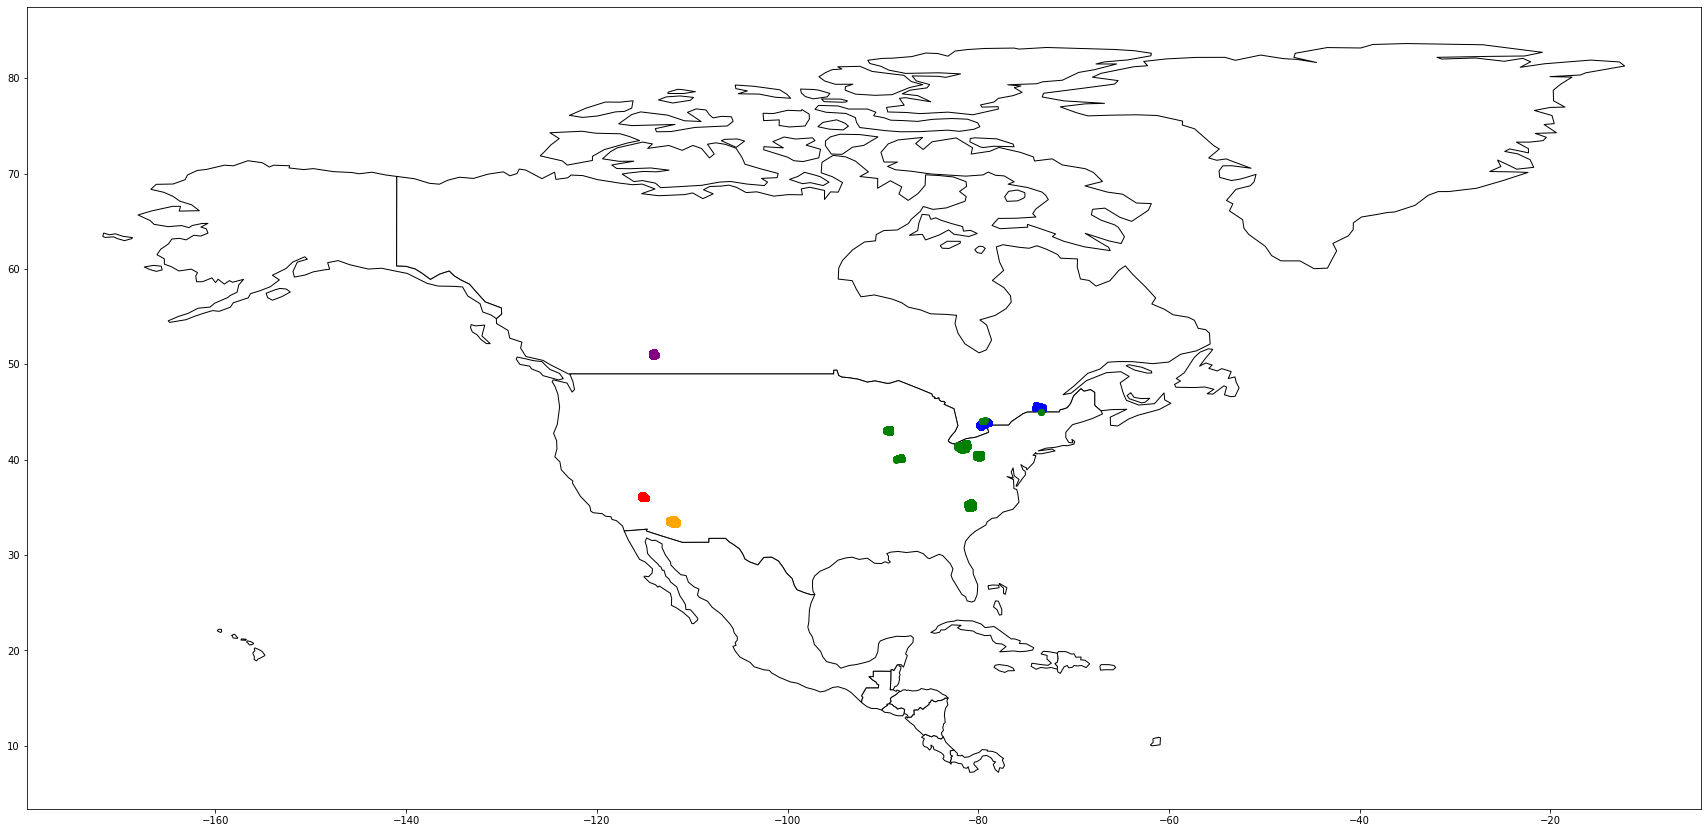

In [93]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize = (30, 30))


colors= ['red', 'blue', 'green', 'purple', 'orange' ] #, 'yellow', 'pink', 'grey', 'brown', 'black']

for key, val in eth_gdf_regions[0].items():
    val.plot(ax=ax, color=colors[key])

plt.savefig('chinese_clusters.png', bbox_inches='tight')

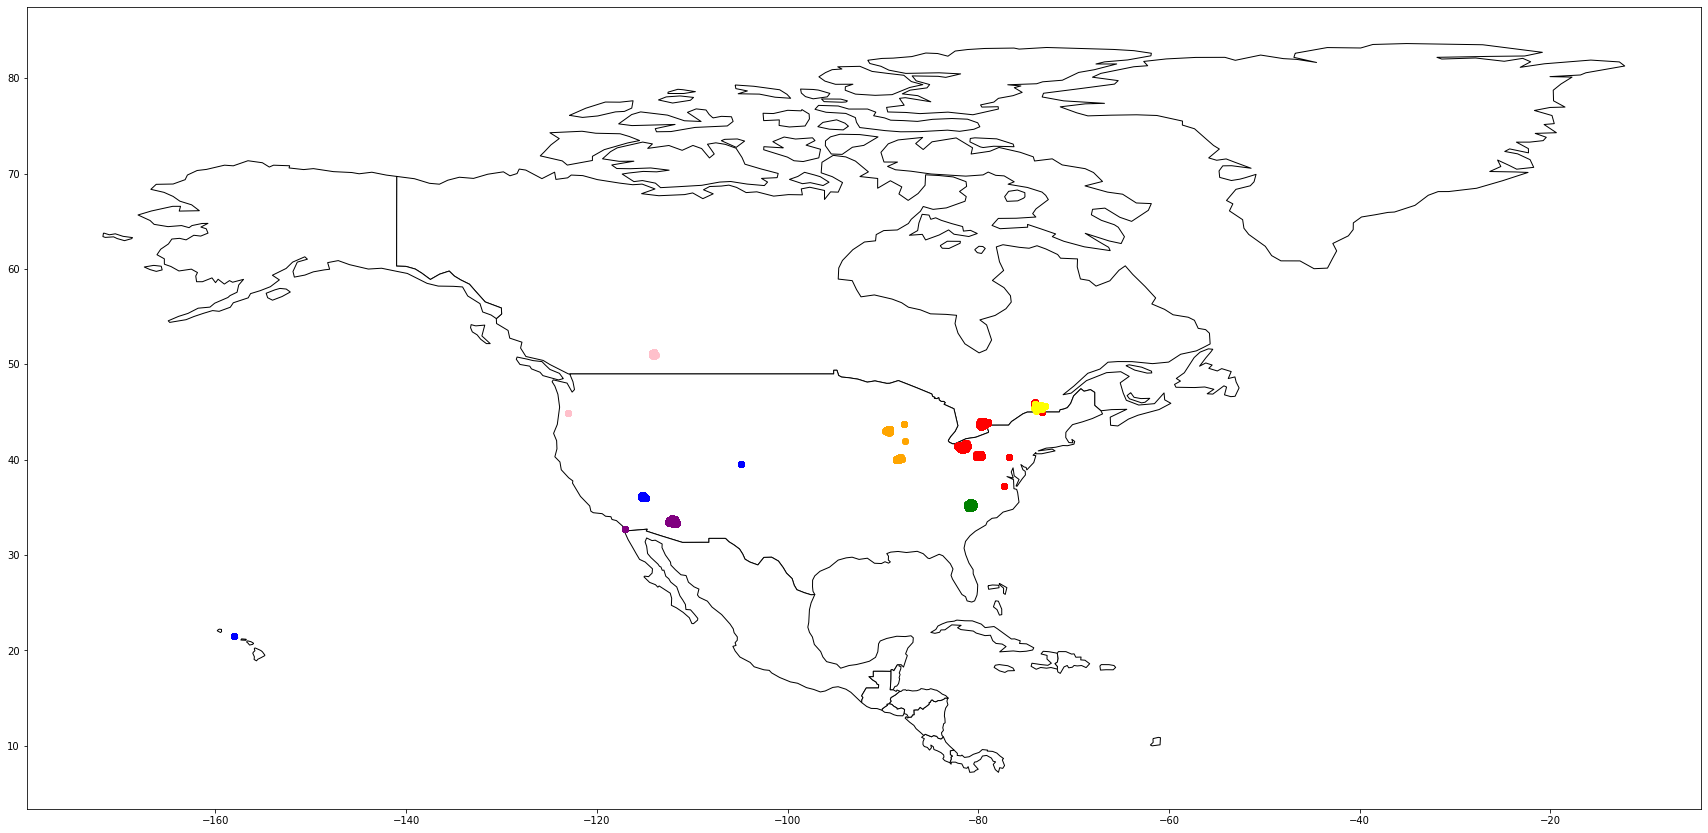

In [94]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize = (30, 30))


colors= ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink'] #, 'grey', 'brown', 'black']

for key, val in eth_gdf_regions[1].items():
    val.plot(ax=ax, color=colors[key])

plt.savefig('italian_clusters.png', bbox_inches='tight')

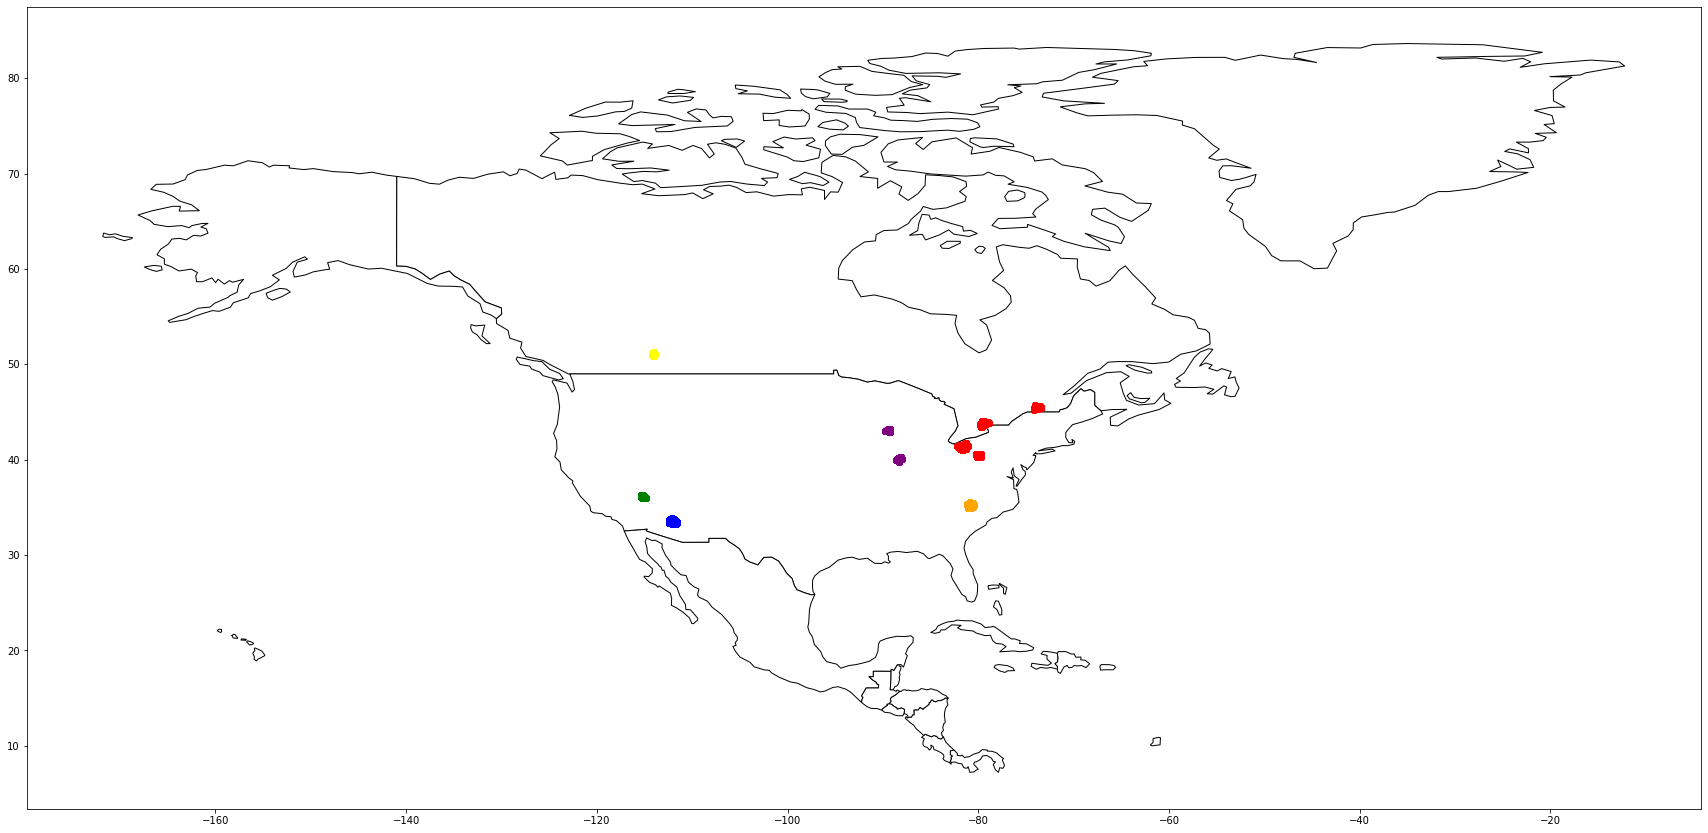

In [95]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize = (30, 30))


colors= ['red', 'blue', 'green', 'purple' , 'orange', 'yellow'] #, 'pink', 'grey', 'brown', 'black']

for key, val in eth_gdf_regions[2].items():
    val.plot(ax=ax, color=colors[key])

plt.savefig('mexican_clusters.png', bbox_inches='tight')